Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40
     Age  Annual Income (k$)  Spending Score (1-100)  Cluster
0     19                  15                      39        2
1     21                  15                      81        2
2     20                  16                       6        0
3     23                  16                      77        2
4     31                  17                      40        0
..  

INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [07/Apr/2025 17:57:26] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [07/Apr/2025 17:57:27] "GET /favicon.ico HTTP/1.1" 404 -


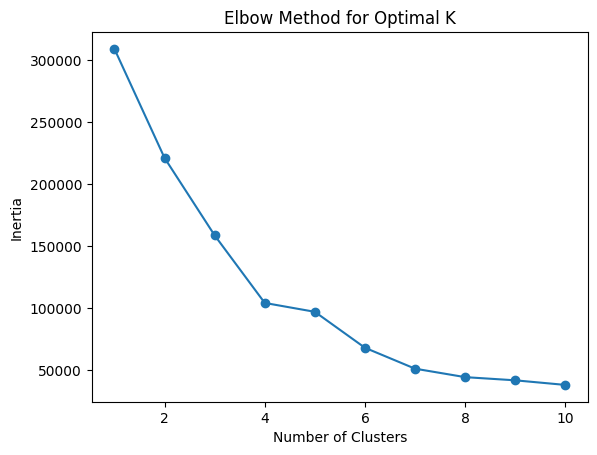

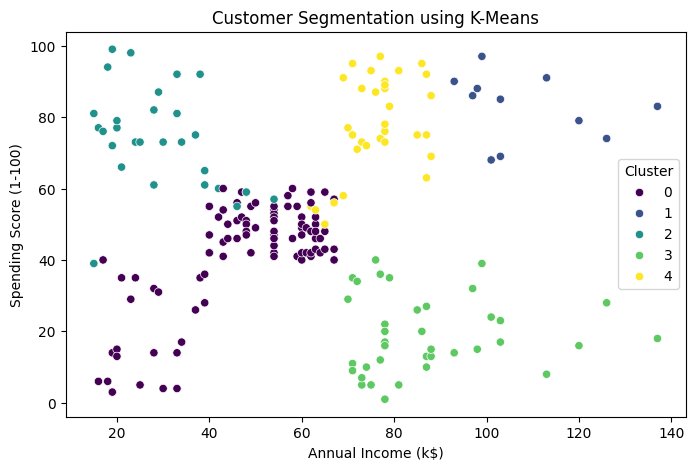

In [2]:
!pip install -q pyngrok flask scikit-learn joblib nltk pandas pyngrok numpy
!ngrok config add-authtoken 2vG8AUJgCvYovOTPXMAMX2ZiFcf_2wi2kAa6tWfd1Hiz7aqyZ
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns
from flask import Flask, jsonify, request, render_template
import joblib
import numpy as np
from pyngrok import ngrok

from google.colab import drive
drive.mount('/content/drive')

# Load dataset
df = pd.read_csv("drive/MyDrive/MyProjects/Mall_Customers.csv")


# Display first few rows
print(df.head())

# Drop rows with missing values
df.dropna(inplace=True)

# Selecting features
X = df[['Age','Annual Income (k$)', 'Spending Score (1-100)']]

# Applying K-means clustering
kmeans = KMeans(n_clusters=5, random_state=42)
df['Cluster'] = kmeans.fit_predict(X)

# Save the trained model
joblib.dump(kmeans, "kmeans_model.pkl")

# Show cluster assignment
print(df[['Age','Annual Income (k$)', 'Spending Score (1-100)', 'Cluster']])

# Find the Optimal Number of Clusters (Elbow Method)
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
# plt.show()

# Visualizing the Clusters
plt.figure(figsize=(8, 5))
sns.scatterplot(x=X['Annual Income (k$)'], y=X['Spending Score (1-100)'], hue=df['Cluster'], palette="viridis")
plt.title("Customer Segmentation using K-Means")
# plt.show()

# Flask app

app = Flask(__name__, template_folder='/content/drive/MyDrive/MyProjects/templates')

# Load trained model
model = joblib.load("kmeans_model.pkl")

# Get cluster centers
cluster_centers = kmeans.cluster_centers_

# Print them for analysis
print("Cluster Centers:\n", cluster_centers)

# Assign labels based on the spending score and income level
sorted_clusters = np.argsort(cluster_centers[:, 2])  # Sort clusters based on Spending Score
cluster_labels = {
    sorted_clusters[0]: "Low-income, low-spending customers",
    sorted_clusters[1]: "Low-income, high-spending customers (deal seekers)",
    sorted_clusters[2]: "Medium-income, medium-spending customers",
    sorted_clusters[3]: "High-income, low-spending customers",
    sorted_clusters[4]: "Elite, high-income, high-spending customers"
}

print("Cluster Mappings:", cluster_labels)  # Debugging

# run_with_ngrok(app)

@app.route('/visualize')
def visualize():
    # Load the dataset (Ensure you have a dataset with similar structure)
    df = pd.read_csv("drive/MyDrive/Mall_Customers.csv")
    df["Cluster"] = model.predict(df[['Age','Annual Income (k$)', 'Spending Score (1-100)']])

    # Create a scatter plot
    plt.figure(figsize=(8,6))
    sns.scatterplot(x=df['Annual Income (k$)'], y=df['Spending Score (1-100)'], hue=df['Cluster'], palette="viridis")
    plt.xlabel('Annual Income')
    plt.ylabel('Spending Score')

    # Save plot
    plt.savefig('drive/MyDrive/static/MyProjects/cluster_plot.png')
    return render_template('visualization.html', image='static/cluster_plot.png')

@app.route('/')  # Home route for the form
def home():
    return render_template("index2.html")  # Render a webpage

@app.route('/predict', methods=['POST'])
def predict():
    data = request.json
    print(f"Received Data: {data}")
    df = pd.DataFrame([data['features']], columns=['Age','Annual Income (k$)', 'Spending Score (1-100)'])
    cluster = model.predict(df)[0]  # Predict the cluster
    cluster_label = cluster_labels.get(sorted_clusters[cluster], "Unknown Cluster")  # Map the cluster to its label
    print(f"Predicted Cluster: {cluster}, Label: {cluster_label}")
    return jsonify({'Cluster': int(cluster), 'Label': cluster_label})  # Convert cluster to int before returning


public_url = ngrok.connect(5000)
print(f" * ngrok tunnel running at: {public_url}")
app.run(port=5000)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
